In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy as sp
from scipy import sparse
from scipy.sparse import linalg

In [5]:
test_data = np.loadtxt(r'./test.txt', delimiter=',')
train_data = np.loadtxt(r'./train.txt', delimiter=',')
Fixed = False

In [6]:
# Fix the indices
if not Fixed:
    train_data[:,0] = train_data[:,0]-1
    train_data[:,1] = train_data[:,1]-1
    test_data[:,0] = test_data[:,0]-1
    test_data[:,1] = test_data[:,1]-1
    Fixed=True

In [7]:
# Data: Ratings by n=24983 users on m=100 jokes (both indexed from 1, but we Fixed that up there ^)
n = 24983
m = 100

In [8]:
train_ratings = sp.sparse.coo_matrix((train_data[:,2], (train_data[:,0],train_data[:,1])), shape=(n,m))
test_ratings = sp.sparse.coo_matrix((test_data[:,2], (test_data[:,0],test_data[:,1])), shape=(n,m))

## Estimators

In [9]:
def mean_squared_error(ratings, U, V):
    residuals = np.einsum('ij,ij->i', U[ratings.row], V[ratings.col]) - ratings.data
    return np.sum(np.square(residuals))/len(ratings.data)

In [10]:
def mean_absolute_error(ratings, U, V):
    users, counts = np.unique(ratings.row, return_counts=True)
    inner = np.abs(np.einsum('ij,ij->i', U[ratings.row], V[ratings.col]) - ratings.data)/counts[ratings.row]
    return np.sum(inner)/len(users)

## (a)
d = 1 ... ish

In [140]:
joke_ratings = [train_data[joke_index, 2] for joke_index in [train_data[:,1] == i for i in range(0,m)]]
mean_ratings = np.array([np.mean(rating) for rating in joke_ratings])

In [150]:
print('problem 5a')
for r in [train_ratings, test_ratings]:
    U = np.ones((len(r.row),1))
    V = mean_ratings[r.col].reshape((len(r.col),1))
    print(mean_squared_error(r, U, V), mean_absolute_error(r, U, V))

problem 5a
30.024150240756097 4.551231195633137
30.58159184091545 4.614872902164382


## (b)

In [129]:
mse_train = []
mse_test = []
mae_train = []
mae_test = []

d_list = [1,2,5,10,20,50]
for d in d_list:
    train_U, train_S, train_Vt = sp.sparse.linalg.svds(train_ratings, k=d)
#     test_U, test_S, test_Vt = sp.sparse.linalg.svds(test_ratings, k=d) Don't train on the test data!
    mse_train.append(mean_squared_error(train_ratings, train_U, train_Vt.T))
    mse_test.append(mean_squared_error(test_ratings, train_U, train_Vt.T))
    mae_train.append(mean_absolute_error(train_ratings, train_U, train_Vt.T))
    mae_test.append(mean_absolute_error(test_ratings, train_U, train_Vt.T))

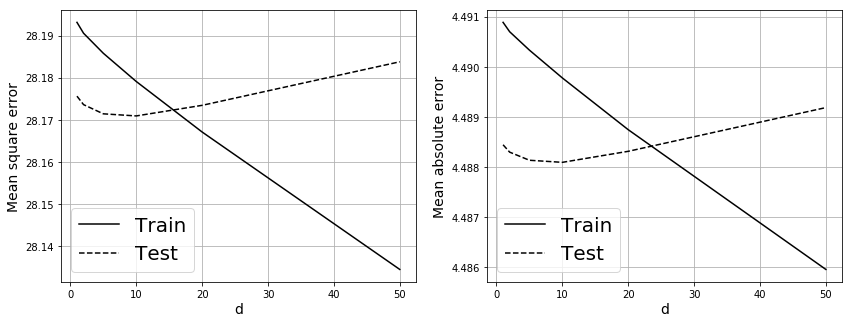

In [133]:
fig, ax = plt.subplots(1,2, figsize=[14,5])

ax[0].plot(d_list, mse_train, c='k', ls='-')
ax[0].plot(d_list, mse_test, c='k', ls='--')
ax[1].plot(d_list, mae_train, c='k', ls='-')
ax[1].plot(d_list, mae_test, c='k', ls='--')

for anax in ax:
    anax.grid(True)
    anax.legend(['Train', 'Test'], fontsize=20, loc='lower left')
    anax.set_xlabel('d', fontsize=14)
    
ax[0].set_ylabel('Mean square error', fontsize=14)
ax[1].set_ylabel('Mean absolute error', fontsize=14)
fig.savefig(r'./figs/mean_square_error.pdf')

## (c)

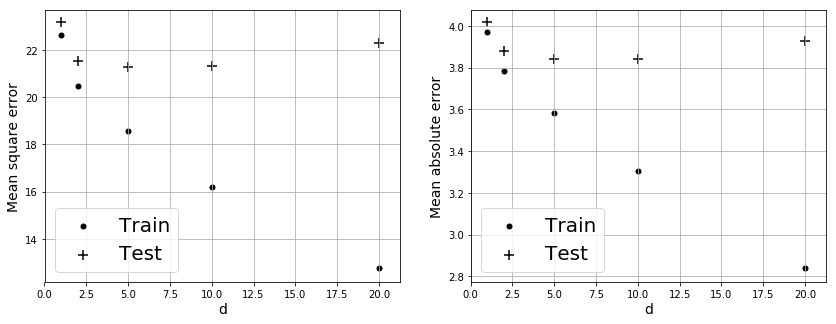

In [32]:
fig, ax = plt.subplots(1,2, figsize=[14,5])

d_list_2 = [1,2,5,10,20]
for d in  d_list_2:
    regularizer = 1
    epsilon = 0.01
    U = np.random.rand(n,d)*20-10
    V = np.random.rand(m,d)*20-10
    loss = mean_squared_error(train_ratings, U, V) + regularizer*(np.linalg.norm(U)+np.linalg.norm(V))
    still_decreasing = True
    while still_decreasing:
        U = np.linalg.pinv((V.T)@(V)+regularizer)@((train_ratings.dot(V)).T)
        U = U.T
        V = np.linalg.pinv((U.T)@(U)+regularizer)@(((train_ratings.transpose()).dot(U)).T)
        V = V.T

        old_loss = np.copy(loss)
        loss = mean_squared_error(train_ratings, U, V) + regularizer*(np.linalg.norm(U)+np.linalg.norm(V))
        still_decreasing = np.abs(loss - old_loss)/old_loss > epsilon

    ax[0].scatter(d, mean_squared_error(train_ratings, U, V), c='k', s=100, marker='.')
    ax[0].scatter(d, mean_squared_error(test_ratings, U, V), c='k', s=100, marker='+')
    ax[1].scatter(d, mean_absolute_error(train_ratings, U, V), c='k', s=100, marker='.')
    ax[1].scatter(d, mean_absolute_error(test_ratings, U, V), c='k', s=100, marker='+')

for anax in ax:
    anax.grid(True)
    anax.legend(['Train', 'Test'], fontsize=20, loc='lower left')
    anax.set_xlabel('d', fontsize=14)

ax[0].set_ylabel('Mean square error', fontsize=14)
ax[1].set_ylabel('Mean absolute error', fontsize=14)
fig.savefig(r'./figs/last_plot.pdf')